In [231]:
import csv
import pandas as pd
import numpy as np

df = pd.read_csv('data/network_intrusion_data.csv')
print(df.shape)

(494020, 42)


In [232]:
df.columns = ['duration', 'protocol_type','service','flag', 'src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
    'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login','is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
     'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate','dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 
     'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'outcome' ] 

In [233]:
#print(type(df['outcome'].values))
#print(df['outcome'].values[0])

for i in range(df['outcome'].values.size):
    if df['outcome'].values[i] == 'normal.':
        df['outcome'].values[i] = 0
    elif df['outcome'].values[i] != 'normal.':
        df['outcome'].values[i] = 1


#print(df['outcome'].head(15))

In [234]:
#dropping duplicate records
df.drop_duplicates(keep='first', inplace=True)
print(df.shape)

(145584, 42)


In [235]:
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
from sklearn import preprocessing
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

In [236]:
#encoding categorical features: protocol type,service, flag
encoded_df = df
categorical_features = pd.Index(['protocol_type', 'service', 'flag'])
for feature in categorical_features:
    encode_text_index(encoded_df, feature)


In [237]:
#encoding numerical features
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

In [238]:
numeric_features = pd.Index(['duration', 'src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
    'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login','is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
     'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate','dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 
     'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate' ])

In [239]:
#encoding numeric features
for feature in numeric_features:
    encode_numeric_zscore(encoded_df, feature)

In [240]:
# dropping columns that were NaN after normalizing
processed_df = encoded_df.drop(columns=['is_host_login', 'num_outbound_cmds'])
print(processed_df.head())

   duration  protocol_type  service  flag  src_bytes  dst_bytes      land  \
0 -0.107851              1       22     9  -0.004261  -0.039036 -0.011722   
1 -0.107851              1       22     9  -0.004263  -0.025042 -0.011722   
2 -0.107851              1       22     9  -0.004272  -0.025042 -0.011722   
3 -0.107851              1       22     9  -0.004273  -0.013613 -0.011722   
4 -0.107851              1       22     9  -0.004273  -0.013613 -0.011722   

   wrong_fragment    urgent      hot  ...  dst_host_srv_count  \
0       -0.084394 -0.004737 -0.07021  ...           -0.967064   
1       -0.084394 -0.004737 -0.07021  ...           -0.879891   
2       -0.084394 -0.004737 -0.07021  ...           -0.792718   
3       -0.084394 -0.004737 -0.07021  ...           -0.705545   
4       -0.084394 -0.004737 -0.07021  ...           -0.618372   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                0.979281               -0.417557   
1                0.979281               

In [241]:
from collections.abc import Sequence
# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)




In [242]:
#splitting data into test and train
x, y = to_xy(processed_df, 'outcome')
outcome = encode_text_index(processed_df,'outcome')
from sklearn.model_selection import train_test_split
import tensorflow as tf
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [243]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn import metrics

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [244]:
y_train = tf.keras.utils.to_categorical(y_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)
#print(y_train.shape)
#print(y_test.shape)


In [245]:
# Define ModelCheckpoint outside the loop
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

#for i in range(5):
print(i)

 # Build network
model = Sequential()
model.add(Dense(20, input_dim=x.shape[1], activation='tanh'))
model.add(Dense(15, activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(5, activation='tanh'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)


print('Training finished...Loading the best model')  

model.load_weights('dnn/best_weights.hdf5') # load weights from best model

# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

y_true = np.argmax(y_test,axis=1)

score = metrics.accuracy_score(y_true, pred)
print("Final accuracy: {}".format(score))

score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))

score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

score = metrics.log_loss(y_test, pred)
print("Log loss score: {}".format(score))

494019
Epoch 1/100
3413/3413 - 2s - loss: 0.0513 - val_loss: 0.0166
Epoch 2/100
3413/3413 - 2s - loss: 0.0144 - val_loss: 0.0117
Epoch 3/100
3413/3413 - 2s - loss: 0.0118 - val_loss: 0.0139
Epoch 4/100
3413/3413 - 2s - loss: 0.0107 - val_loss: 0.0097
Epoch 5/100
3413/3413 - 2s - loss: 0.0096 - val_loss: 0.0088
Epoch 6/100
3413/3413 - 2s - loss: 0.0094 - val_loss: 0.0092
Epoch 7/100
3413/3413 - 2s - loss: 0.0086 - val_loss: 0.0090
Epoch 8/100
3413/3413 - 2s - loss: 0.0083 - val_loss: 0.0075
Epoch 9/100
3413/3413 - 2s - loss: 0.0080 - val_loss: 0.0085
Epoch 10/100
3413/3413 - 2s - loss: 0.0076 - val_loss: 0.0080
Epoch 11/100
3413/3413 - 2s - loss: 0.0073 - val_loss: 0.0080
Epoch 12/100
3413/3413 - 2s - loss: 0.0073 - val_loss: 0.0080
Epoch 13/100
3413/3413 - 2s - loss: 0.0070 - val_loss: 0.0072
Epoch 00013: early stopping
Training finished...Loading the best model
Final accuracy: 0.9980217606330366
Precision score: 0.9980227001421607
Recall score: 0.9980217606330366
F1 score: 0.998021975

[[21977    45]
 [   27 14347]]
Plotting confusion matrix


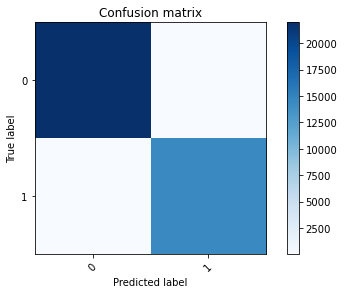

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22022
           1       1.00      1.00      1.00     14374

    accuracy                           1.00     36396
   macro avg       1.00      1.00      1.00     36396
weighted avg       1.00      1.00      1.00     36396



In [246]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()

print(classification_report(y_true, pred))

In [247]:
########## CONVOLUTIONAL NEURAL NETWORK MODEL ##########

In [248]:
x2, y2 = to_xy(processed_df, 'outcome')
x2 = x2.reshape(145584, 1, 39, 1)
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.25, random_state=42)

print(x2.shape)

print(x2_train.shape)
print(x2_test.shape)
print(y2.shape)
print(y2_train.shape)
print(y2_test.shape)

(145584, 1, 39, 1)
(109188, 1, 39, 1)
(36396, 1, 39, 1)
(145584, 2)
(109188, 2)
(36396, 2)


In [249]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

cnn = Sequential()
cnn.add(Conv2D(filters=2, kernel_size=(1,3), strides=(1,1),
        activation='relu', input_shape=(1, 39, 1)))

cnn.add(MaxPooling2D(pool_size=(1,2)))
cnn.add(Flatten())
cnn.add(Dense(100, activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(2, activation="softmax"))

cnn.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")

In [250]:
import time

start_time = time.time()

# 1% of dataset

cnn.fit(x2_train[0:600], y2_train[0:600],     
          batch_size=32,
          epochs=10,
          verbose=2,
          validation_data=(x2_test[0:100], y2_test[0:100]))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))


Epoch 1/10
19/19 - 0s - loss: 1.4257 - accuracy: 0.4933 - val_loss: 0.6098 - val_accuracy: 0.8800
Epoch 2/10
19/19 - 0s - loss: 1.0964 - accuracy: 0.5717 - val_loss: 0.4806 - val_accuracy: 0.8900
Epoch 3/10
19/19 - 0s - loss: 0.8448 - accuracy: 0.6617 - val_loss: 0.3831 - val_accuracy: 0.9100
Epoch 4/10
19/19 - 0s - loss: 0.5863 - accuracy: 0.7683 - val_loss: 0.3053 - val_accuracy: 0.9100
Epoch 5/10
19/19 - 0s - loss: 0.5300 - accuracy: 0.8400 - val_loss: 0.2467 - val_accuracy: 0.9200
Epoch 6/10
19/19 - 0s - loss: 0.3985 - accuracy: 0.8733 - val_loss: 0.2071 - val_accuracy: 0.9400
Epoch 7/10
19/19 - 0s - loss: 0.3233 - accuracy: 0.9033 - val_loss: 0.1793 - val_accuracy: 0.9600
Epoch 8/10
19/19 - 0s - loss: 0.2713 - accuracy: 0.9067 - val_loss: 0.1577 - val_accuracy: 0.9500
Epoch 9/10
19/19 - 0s - loss: 0.2380 - accuracy: 0.9217 - val_loss: 0.1400 - val_accuracy: 0.9700
Epoch 10/10
19/19 - 0s - loss: 0.1986 - accuracy: 0.9500 - val_loss: 0.1178 - val_accuracy: 0.9700
Elapsed time: 0:00:

In [251]:
score = cnn.evaluate(x2_test[0:100], y2_test[0:100], verbose=0)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

Test loss: 0.1177791878581047
Test accuracy: 0.9700000286102295


In [252]:
from sklearn import metrics

y2_true = np.argmax(y2_test[0:500],axis=1)
cnn_pred = cnn.predict(x2_test[0:500])
cnn_pred = np.argmax(cnn_pred,axis=1)


score = metrics.accuracy_score(y2_true, cnn_pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y2_true, cnn_pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y2_true, cnn_pred))

Accuracy: 0.968
Averaged F1: 0.967825993555317
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       298
           1       0.99      0.93      0.96       202

    accuracy                           0.97       500
   macro avg       0.97      0.96      0.97       500
weighted avg       0.97      0.97      0.97       500



[[296   2]
 [ 14 188]]
Plotting confusion matrix


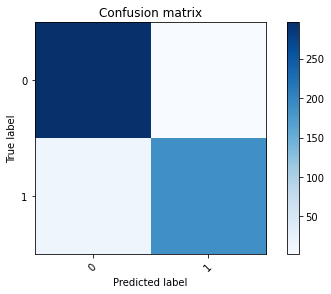

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22022
           1       1.00      1.00      1.00     14374

    accuracy                           1.00     36396
   macro avg       1.00      1.00      1.00     36396
weighted avg       1.00      1.00      1.00     36396



In [253]:
# Compute confusion matrix
cm = confusion_matrix(y2_true, cnn_pred)
print(cm)


print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, outcome)
plt.show()

print(classification_report(y_true, pred))